# HOMEWORK TASK 2

## Mehmet Atakan Çavuşlu & Tor Anders Høksås  - Group MMA 191



In [1]:
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

### For this assignment we will use data from the worldbank API with "wbdata", a simple python interface to find and request information from the World Bank’s various databases as seen below: 

In [ ]:
wbdata.get_source() # Example of available databases from WorldBank

In [ ]:
wbdata.search_indicators('Enrollment')

# For our analysis we will do a Regression problem


## We are trying to see how "Investment in education and subsequent performance of education influences GDP" 

### In order to see that we have decided to take the following data available from the World Bank Database.

### Year of Analysis: 2014

### Variables will be: 


#### Dependent:

- NY.GDP.MKTP.CD --- GDP (current USD)

#### Independent:

- SE.XPD.TOTL.GB.ZS --- Government expenditure on education, total (% of government expenditure)
- SE.XPD.PRIM.PC.ZS --- Government expenditure per student, primary (% of GDP per capita)
- SE.XPD.SECO.PC.ZS --- Government expenditure per student, secondary (% of GDP per capita)
- SE.XPD.TERT.PC.ZS --- Government expenditure per student, tertiary (% of GDP per capita)
- SE.PRM.ENRR --- School enrollment, primary (% net)
- SE.SEC.ENRR --- School enrollment, secondary (% net)
- SE.TER.ENRR --- School enrollment, tertiary (% gross)







#### Gathering Data and Variables from WorldBank API

In [2]:
# Set the date as 2014, since it has the most avaiable data (based on previous analysis)
data_date = (datetime.datetime(2014, 1, 1))
# Set the indicator names to pull from API
indicators = {
    "NY.GDP.MKTP.CD": "GDP_USD",
    "SE.XPD.TOTL.GB.ZS": "Gov_Ed_Expenditure_EXP",
    "SE.XPD.PRIM.PC.ZS": "Gov_Exp_Per_Std_Primary",
    "SE.XPD.SECO.PC.ZS": "Gov_Exp_Per_Std_Secondary",
    "SE.XPD.TERT.PC.ZS": "Gov_Exp_Per_Std_Tertiary",
    "SE.PRM.ENRR": "Primary_School_Enroll",  
    "SE.SEC.ENRR": "Secondary_School_Enroll",
    "SE.TER.ENRR": "Tertiary_School_Enroll"
}  

df = wbdata.get_dataframe(indicators, data_date=data_date)

# Exploratory Data Analysis (EDA)

In [3]:
df.count() # Count of data available for each column 

GDP_USD                      252
Gov_Ed_Expenditure_EXP       153
Gov_Exp_Per_Std_Primary      111
Gov_Exp_Per_Std_Secondary     98
Gov_Exp_Per_Std_Tertiary      96
Primary_School_Enroll        207
Secondary_School_Enroll      184
Tertiary_School_Enroll       173
dtype: int64

In [4]:
df.isnull().sum() # Total Missing values per column

GDP_USD                       12
Gov_Ed_Expenditure_EXP       111
Gov_Exp_Per_Std_Primary      153
Gov_Exp_Per_Std_Secondary    166
Gov_Exp_Per_Std_Tertiary     168
Primary_School_Enroll         57
Secondary_School_Enroll       80
Tertiary_School_Enroll        91
dtype: int64

__As initial Missing Data Manipulation we will remove the missing values as these serve no purpose to our analysis.__

Other option would be setting a threshold to remove only rows with more than 1 NaN values, then using a package like "missingpy" to predict these NaN values based on their correlation with other given variables. But for the scope of his HW, removing them all together is sufficient, given that we still have large enough dataset to work with afterwards.

Using basic imputings like means etc. would cause severe sway in our data since missing data is usually from not mean countries but rather edge countries (too poor etc.)

In [5]:
df.dropna(inplace = True) 

In [6]:
df.count()

GDP_USD                      65
Gov_Ed_Expenditure_EXP       65
Gov_Exp_Per_Std_Primary      65
Gov_Exp_Per_Std_Secondary    65
Gov_Exp_Per_Std_Tertiary     65
Primary_School_Enroll        65
Secondary_School_Enroll      65
Tertiary_School_Enroll       65
dtype: int64

__It seems like government spendings per student variables give a lot of NaN values, thus causing us to omit a lot of rows. Let's try without them to see if we can get better number of observations.__

In [7]:
data_date = (datetime.datetime(2014, 1, 1))
indicators = {
    "NY.GDP.MKTP.CD": "GDP_USD",
    "SE.XPD.TOTL.GB.ZS": "Gov_Ed_Expenditure_EXP",
    "SE.PRM.ENRR": "Primary_School_Enroll",  
    "SE.SEC.ENRR": "Secondary_School_Enroll",
    "SE.TER.ENRR": "Tertiary_School_Enroll"
}  
df = wbdata.get_dataframe(indicators, data_date=data_date)

In [8]:
df.dropna(inplace = True)

In [9]:
df.count()

GDP_USD                    110
Gov_Ed_Expenditure_EXP     110
Primary_School_Enroll      110
Secondary_School_Enroll    110
Tertiary_School_Enroll     110
dtype: int64

__Without them our data has considerably more observations. We will use these remaining 5 variables. More trials with other variables can be tried for future work and more causality analysis. But for our HW we think these variables will be sufficient.__

In [10]:
df.head()

,GDP_USD,Gov_Ed_Expenditure_EXP,Primary_School_Enroll,Secondary_School_Enroll,Tertiary_School_Enroll
country,,,,,
Caribbean small states,7.298914e+10,21.797490,99.54082,85.56196,22.91996
Central Europe and the Baltics,1.465594e+12,11.274320,98.34762,102.18820,62.08801
Early-demographic dividend,1.059669e+13,16.945705,106.17120,72.57747,27.92243
East Asia & Pacific,2.187868e+13,14.275945,100.45400,84.28538,41.39086
East Asia & Pacific (IDA & IBRD countries),1.268696e+13,13.212725,100.49860,82.21957,38.44768


In [11]:
df.describe() # Summary statistics for our dataframe

,GDP_USD,Gov_Ed_Expenditure_EXP,Primary_School_Enroll,Secondary_School_Enroll,Tertiary_School_Enroll
count,1.100000e+02,110.000000,110.000000,110.000000,110.000000
mean,5.180109e+12,15.179648,103.760412,84.944633,42.874356
std,1.235648e+13,3.798552,9.947645,27.308084,27.025657
min,3.489417e+08,8.006470,77.076110,30.354030,4.818540
25%,3.188401e+10,12.311522,99.718587,66.883713,16.755872
50%,3.519491e+11,14.543753,101.975050,92.609245,42.912755
75%,2.381779e+12,17.512915,105.988800,103.898270,66.823698
max,7.933444e+13,25.653620,145.247860,162.299340,91.500160


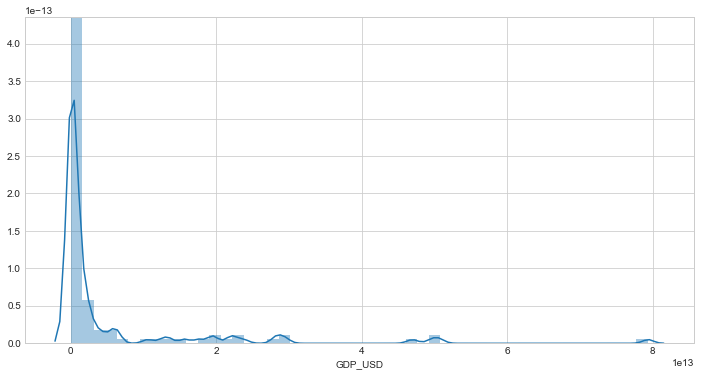

In [12]:
sns.distplot(df['GDP_USD'])

Our outcome variable __GDp_USD__ distribution is heavily skewed to the right and somewhat far from normal distribution. It may cause problems for model fitting since relative errors for low GDP and high GDP countries are treated unevenly. Taking the log helps to overcome this problem.

In [13]:
#transform outcome variable to be Gaussian
df['ln_GDP_USD'] = np.log(df['GDP_USD'])

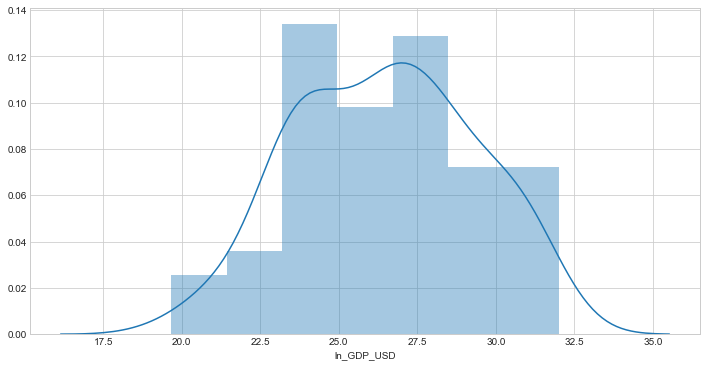

In [14]:
sns.distplot(df['ln_GDP_USD'])

We can use correlation maps to see which variables correlates with our outcome variable, and to see which variables correlates with each other

In [15]:
df.iloc[:,:].corr()

,GDP_USD,Gov_Ed_Expenditure_EXP,Primary_School_Enroll,Secondary_School_Enroll,Tertiary_School_Enroll,ln_GDP_USD
GDP_USD,1.000000,-0.140827,-0.063887,0.080080,0.163448,0.639480
Gov_Ed_Expenditure_EXP,-0.140827,1.000000,0.086927,-0.368721,-0.441750,-0.240430
Primary_School_Enroll,-0.063887,0.086927,1.000000,-0.045173,-0.136521,-0.139657
Secondary_School_Enroll,0.080080,-0.368721,-0.045173,1.000000,0.852028,0.187527
Tertiary_School_Enroll,0.163448,-0.441750,-0.136521,0.852028,1.000000,0.307084
ln_GDP_USD,0.639480,-0.240430,-0.139657,0.187527,0.307084,1.000000


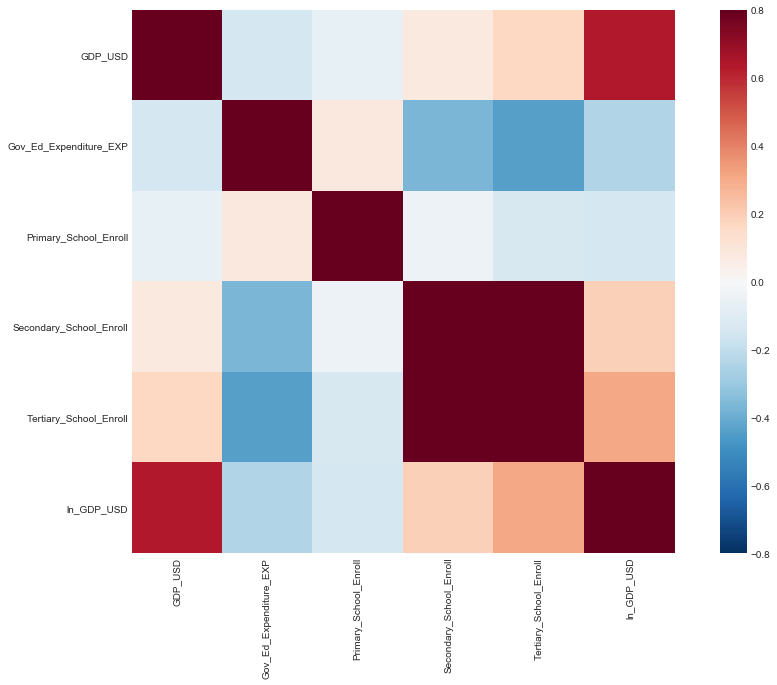

In [16]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corrmat,vmin=-.8, vmax=.8, square=True, cmap='RdBu_r')

Pairplot to see individual distributions of variables as well as correlations with each other.

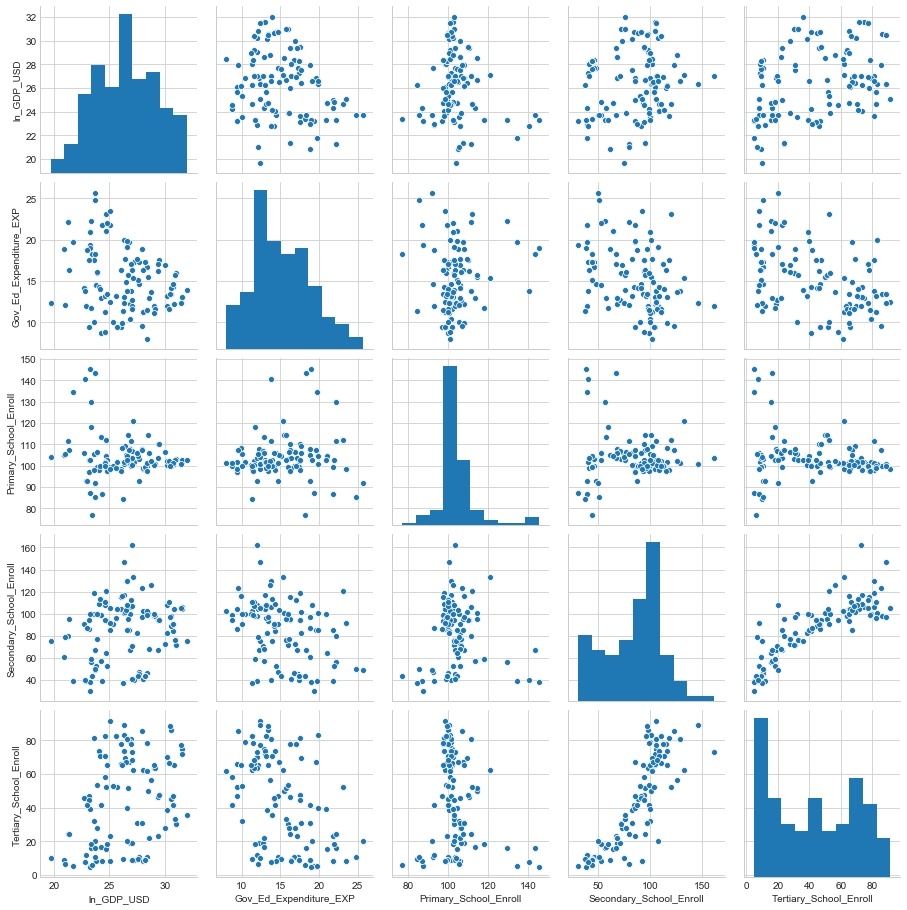

In [17]:
#scatter plots
cols = ['ln_GDP_USD', 'Gov_Ed_Expenditure_EXP', 'Primary_School_Enroll', 'Secondary_School_Enroll','Tertiary_School_Enroll']
sns.pairplot(df[cols], height = 2.5)
plt.show()

Even though it seems there's really strong correlation between Secondary_Enroll and Tertiary_Enroll, we chose to keep them in our model because even though in numbers they are very correlated, as an insight we believe they might contribute the model independently. Especially considering their varied correlations with outcome variable (one is the double of another)

__Furthermore we will check for Multicollinearity using Variance Inflation Factor (VIF)__

In [18]:
%%capture
#gather features
features = "+".join(df.columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('ln_GDP_USD ~' + features, df, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns


In [19]:
vif.round(1)

,VIF Factor,features
0,0.0,Intercept
1,1.7,GDP_USD
2,1.3,Gov_Ed_Expenditure_EXP
3,1.0,Primary_School_Enroll
4,3.8,Secondary_School_Enroll
5,4.3,Tertiary_School_Enroll
6,1.9,ln_GDP_USD


__If the VIF is between 5-10, multicolinearity might be present as we have high value of 4.3 in Tertiary. But even though they are not perfect we find these to be satisfactory enough to keep all the variables. Further complementing our previous idea.__

Our Final dataset:

In [20]:
df.head()

,GDP_USD,Gov_Ed_Expenditure_EXP,Primary_School_Enroll,Secondary_School_Enroll,Tertiary_School_Enroll,ln_GDP_USD
country,,,,,,
Caribbean small states,7.298914e+10,21.797490,99.54082,85.56196,22.91996,25.013576
Central Europe and the Baltics,1.465594e+12,11.274320,98.34762,102.18820,62.08801,28.013282
Early-demographic dividend,1.059669e+13,16.945705,106.17120,72.57747,27.92243,29.991563
East Asia & Pacific,2.187868e+13,14.275945,100.45400,84.28538,41.39086,30.716534
East Asia & Pacific (IDA & IBRD countries),1.268696e+13,13.212725,100.49860,82.21957,38.44768,30.171596


In [21]:
df.describe()

,GDP_USD,Gov_Ed_Expenditure_EXP,Primary_School_Enroll,Secondary_School_Enroll,Tertiary_School_Enroll,ln_GDP_USD
count,1.100000e+02,110.000000,110.000000,110.000000,110.000000,110.000000
mean,5.180109e+12,15.179648,103.760412,84.944633,42.874356,26.489355
std,1.235648e+13,3.798552,9.947645,27.308084,27.025657,2.838195
min,3.489417e+08,8.006470,77.076110,30.354030,4.818540,19.670415
25%,3.188401e+10,12.311522,99.718587,66.883713,16.755872,24.185007
50%,3.519491e+11,14.543753,101.975050,92.609245,42.912755,26.586748
75%,2.381779e+12,17.512915,105.988800,103.898270,66.823698,28.497346
max,7.933444e+13,25.653620,145.247860,162.299340,91.500160,32.004693


Lets also try scaling the data into two new dataframes, to check if they improve our models.

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Min Max scaling, distortion free
minmax_scaler = MinMaxScaler()
df_minmax = df.copy()
df_minmax[df.columns] = minmax_scaler.fit_transform(df[df.columns])
# StandardScaling to make it normally distributed
standard_scaler = StandardScaler()
df_standard = df.copy()
df_standard[df.columns] = standard_scaler.fit_transform(df[df.columns])

In [23]:
df_minmax.describe()

,GDP_USD,Gov_Ed_Expenditure_EXP,Primary_School_Enroll,Secondary_School_Enroll,Tertiary_School_Enroll,ln_GDP_USD
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.065290,0.406478,0.391428,0.413737,0.439030,0.552845
std,0.155752,0.215250,0.145920,0.206965,0.311781,0.230106
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000397,0.243952,0.332139,0.276855,0.137715,0.366020
50%,0.004432,0.370444,0.365238,0.471826,0.439473,0.560741
75%,0.030018,0.538696,0.424115,0.557384,0.715321,0.715642
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
df_standard.describe()

,GDP_USD,Gov_Ed_Expenditure_EXP,Primary_School_Enroll,Secondary_School_Enroll,Tertiary_School_Enroll,ln_GDP_USD
count,1.100000e+02,1.100000e+02,1.100000e+02,1.100000e+02,1.100000e+02,1.100000e+02
mean,-3.179275e-17,2.745279e-16,-1.877286e-16,-5.939693e-16,-5.914461e-16,2.061987e-15
std,1.004577e+00,1.004577e+00,1.004577e+00,1.004577e+00,1.004577e+00,1.004577e+00
min,-4.211123e-01,-1.897041e+00,-2.694751e+00,-2.008213e+00,-1.414581e+00,-2.413558e+00
25%,-4.185485e-01,-7.585133e-01,-4.081692e-01,-6.644032e-01,-9.708559e-01,-8.156219e-01
50%,-3.925274e-01,-1.681709e-01,-1.802972e-01,2.819564e-01,1.427351e-03,3.447210e-02
75%,-2.275031e-01,6.170630e-01,2.250368e-01,6.972434e-01,8.902263e-01,7.107267e-01
max,6.028715e+00,2.769979e+00,4.189667e+00,2.845631e+00,1.807481e+00,1.952149e+00


### We selected regression models, since our outcome variable is numerical, not categorical.

## OLS Linear Regression 

In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression() #initiate the model with default parameters
X = df.loc[:,['Gov_Ed_Expenditure_EXP','Primary_School_Enroll','Secondary_School_Enroll','Tertiary_School_Enroll']]
y = df.loc[:,'ln_GDP_USD'] 
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
lr.intercept_ #model intercept

30.37396589907283

In [27]:
pd.Series(lr.coef_, index=X.columns) #model coefficients

Gov_Ed_Expenditure_EXP    -0.093578
Primary_School_Enroll     -0.022344
Secondary_School_Enroll   -0.025632
Tertiary_School_Enroll     0.047384
dtype: float64

In [28]:
lr.score(X,y) #the coefficient of determination R^2 of the prediction

0.13335522008181233

Very low R-square score. It means our model does perform bad. Let's investigate if it caused by non-scaled data. This time we use our scaled dataframes, both minmax and standardized:

__Applying OLS to minmax scaled dataframe__

In [29]:
lr_minmax = LinearRegression()
X_minmax = df_minmax.loc[:,['Gov_Ed_Expenditure_EXP','Primary_School_Enroll','Secondary_School_Enroll','Tertiary_School_Enroll']]
y_minmax = df_minmax.loc[:,'ln_GDP_USD'] 
lr_minmax.fit(X_minmax,y_minmax)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
lr_minmax.score(X_minmax,y_minmax) #the coefficient of determination R^2 of the prediction

0.13335522008181233

Still low R^2, that was expected since minmax does not change the behaviour of data distribution. __Lets try this time with standardized scaling__, which made the data closer to normal distribution.

In [32]:
lr_std = LinearRegression()
X_std = df_standard.loc[:,['Gov_Ed_Expenditure_EXP','Primary_School_Enroll','Secondary_School_Enroll','Tertiary_School_Enroll']]
y_std = df_standard.loc[:,'ln_GDP_USD'] 
lr_std.fit(X_std,y_std)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
lr_std.score(X_std,y_std) #the coefficient of determination R^2 of the prediction

0.13335522008181255

Unfortunately, the model still performs bad. Even though we can easily see we have already bad performing model, lets check cros-validations and overfitting. We use 5-fold cross validation.

In [39]:
from sklearn.model_selection import cross_val_score
sk = cross_val_score(lr, X, y, cv=5)
sk_minmax = cross_val_score(lr_minmax, X_minmax, y_minmax, cv=5)
sk_std = cross_val_score(lr_std, X_std, y_std, cv=5)
print("Mean score (OLS, rawData): {:.2f}".format(np.mean(sk)))
print("Mean score (OLS, minmaxScaled): {:.2f}".format(np.mean(sk_minmax)))
print("Mean score (OLS, standardScaled): {:.2f}".format(np.mean(sk_std)))

Mean score (OLS, rawData): -1.52
Mean score (OLS, minmaxScaled): -1.52
Mean score (OLS, standardScaled): -1.52


We get even negative scores, which means actually the underlying data is far from being linear. Thus how much we try with simple linear models, we will not get any satisfacory results. 

Implications of negative scores can be found here in more detail: https://en.wikipedia.org/wiki/Coefficient_of_determination

__Let us try adding polynomial models this time.__

## Polynomials - Adding Higher Degrees to the Regression Model

In [34]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X) #transform X to higher order polynomials

In [40]:
lr.fit(X_poly,y)
sk_poly = cross_val_score(lr, X_poly, y, cv=5)
print("Mean score (LR, poly): {:.2f}".format(np.mean(sk_poly)))

Mean score (LR, poly): -1.22


We still have bad performing score, let us try the standardized version of the dataframe.

In [41]:
X_std_poly = poly.fit_transform(X_std) #transform X to higher order polynomials
lr_std.fit(X_std_poly,y_std)
sk_std_poly = cross_val_score(lr_std, X_std_poly, y_std, cv=5)
print("Mean score (LR_std, poly): {:.2f}".format(np.mean(sk_std_poly)))

Mean score (LR_std, poly): -1.22


We still have bad models, mainly because of the above discussion, the non-linear distribution of data. With our findings, we can say that there's no linear causality between these variables and our outcome variable. 

__For the sake of trying, let us also try Decision Trees to see if we can come up with somewhat fitting model__

## Decision Tree Regression

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
# Using non_scaled, raw data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
tree = DecisionTreeRegressor(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: -0.114


Still bad scores. Lets try to decrease overfitting by setting tree depth, and try again to see if it improves.

In [50]:
tree = DecisionTreeRegressor(max_depth=6, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.924
Accuracy on test set: -0.714


Even worse results. 

For the last try, let us use __standardized and minmax scaled dataframes__ to check if they significanlty increase model accuracy (Even though we expect still somewhat bad performing models) 

At this point maybe there is no significant causality in the data, or we need to use more complex algorithms like Neural Networks, since the data gives no clear model with basic models

In [53]:
# Using minmax scaled data
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax, y_minmax, test_size = 0.2, random_state = 0)
tree = DecisionTreeRegressor(max_depth=6, random_state=0)
tree.fit(X_train_minmax, y_train_minmax)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train_minmax, y_train_minmax)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test_minmax, y_test_minmax)))

Accuracy on training set: 0.924
Accuracy on test set: -0.463


In [54]:
# Using standardized data
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std, test_size = 0.2, random_state = 0)
tree = DecisionTreeRegressor(max_depth=6, random_state=0)
tree.fit(X_train_std, y_train_std)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train_std, y_train_std)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test_std, y_test_std)))

Accuracy on training set: 0.924
Accuracy on test set: -0.720


At the end, it seems like we are not getting any proper working model. The above statements hold. Right now, we cannot show any significant causality or correlations with these variables on the outcome varaible. Usage of more complex models is advised. 

__For this HW we cut it here since the main idea was showing and applying basic ML work, which we tried to do here.__ 

For further academical implications, data and analysis can be worked on to change hypothesis, to change varaibles, to change models or all together.